# Path Visualization and Optimization for AWS DeepRacer

In [77]:
from os import listdir
from os.path import isfile, join, exists, splitext

import math
import numpy as np

from scipy.interpolate import CubicSpline, BPoly

import pickle

import matplotlib
import matplotlib.pyplot as plt

from ipywidgets import interact
import ipywidgets as widgets

# matplotlib.use('webagg')

%matplotlib notebook

matplotlib.rcParams['savefig.dpi'] = 80
matplotlib.rcParams['figure.dpi'] = 80

In [86]:
def wrap_360(theta):
    theta = theta % 360
    theta = (theta + 360) % 360
    
    return theta


def convert_slope(m):
    return math.atan2(m[1], m[0])


def get_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)


def get_nearest_point(waypoints, point):
    min_i = None
    min_distance = math.inf

    for i, waypoint in enumerate(waypoints):
        distance = get_distance(waypoint, point)
        if distance < min_distance:
            min_i = i
            min_distance = distance
    
    return min_i


def get_best_position(waypoints, point):
    i1 = get_nearest_point(waypoints, point)
    p1 = waypoints[i1]
    
    i2 = i1 + 1
    if i2 > len(waypoints)-1:
        i2 = 0

    p2 = waypoints[i2]
    
    m = [p2[0] - p1[0], p2[1] - p1[1]]
    
    return p1, m

In [79]:
def sample_cubic_spline(points, tangents, scales, resolution):
    '''
    Compute and sample the cubic splines for a set of input points with
    optional information about the tangent (direction AND magnitude). The 
    splines are parametrized along the traverse line (piecewise linear), with
    the resolution being the step size of the parametrization parameter.
    The resulting samples have NOT an equidistant spacing.

    Arguments:      points: a list of n-dimensional points
                    tangents: a list of tangents
                    resolution: parametrization step size
    Returns:        samples

    Notes: Lists points and tangents must have equal length. In case a tangent
           is not specified for a point, just pass None. For example:
                    points = [[0,0], [1,1], [2,0]]
                    tangents = [[1,1], None, [1,-1]]

    '''
    resolution = float(resolution)
    points = np.asarray(points)
    num_points, dim = points.shape

    # parametrization parameter s.
    dp = np.diff(points, axis=0)                 # difference between points
    dp = np.linalg.norm(dp, axis=1)              # distance between points
    d = np.cumsum(dp)                            # cumsum along the segments
    d = np.hstack([[0], d])                      # add distance from first point
    l = d[-1]                                    # length of point sequence
    num_samples = int(l/resolution)              # number of samples
    s, r = np.linspace(0, l, num_samples, retstep=True) # sample parameter and step

    # Bring points and (optional) tangent information into correct format.
    assert(len(points) == len(tangents))
    
    data = np.empty([num_points, dim], dtype=object)
    
    for i, p in enumerate(points):
        t = tangents[i]
        scale = scales[i]
        
        if not t is None and not scale is None:
            t = np.multiply(t, scale)
            
        # either tangent is None or has the same
        # number of dimensions as the point p.
        assert(t is None or len(t) == dim)
        fuse = list(zip(p, t) if t is not None else zip(p,))
        data[i, :] = fuse

    # compute splines per dimension separately.
    samples = np.zeros([num_samples, dim])
    
    for i in range(dim):
        poly = BPoly.from_derivatives(d, data[:, i])
        samples[:, i] = poly(s)

    return samples

## Visualize Track Waypoints

In [80]:
def plot_track_waypoints(ax, points):
    x = points[:,0]
    y = points[:,1]
    ax.plot(x, y, linewidth=5, alpha=.25)
    
    
def plot_track(ax, track_waypoints):
    plot_track_waypoints(ax, track_waypoints[:,0:2])
    plot_track_waypoints(ax, track_waypoints[:,2:4])
    plot_track_waypoints(ax, track_waypoints[:,4:6])


def get_track_waypoints(track):
    return np.load("./tracks/%s.npy" % track)

tracks = [splitext(f)[0] for f in listdir("tracks/") if isfile(join("tracks/", f))]

def track_selected(x):
    track_waypoints = get_track_waypoints(x)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('equal')

    plot_track(ax, track_waypoints)
    
interact(track_selected, x=tracks)

interactive(children=(Dropdown(description='x', options=('Oval_track', 'ChampionshipCup2019_track', 'New_York_…

<function __main__.track_selected(x)>

## The Reward Function

In [81]:
def reward_function(params):
    # Read input parameters    
    is_reversed = params['is_reversed']
    all_wheels_on_track = params['all_wheels_on_track']
    track_width = params['track_width']
    distance_from_center = params['distance_from_center']
    heading = params['heading']
    x = params['x']
    y = params['y']
    
    heading = wrap_360(heading)
    
    position = [x, y]
    
    # Give a very low reward by default
    reward = 1e-3

    best_position, slope = get_best_position(waypoints, position)
    best_heading = wrap_360(math.degrees(convert_slope(slope)))
    
    best_position_diff = get_distance(position, best_position)
    best_heading_diff = abs(heading - best_heading)

    if not is_reversed:
        reward = 1.0

    position_reward = (1 + (1 - math.tanh(best_position_diff))) ** 2
    heading_reward = (1 + (1 - best_heading_diff / 360)) ** 2
    
    reward *= (position_reward * heading_reward) ** 2
    
    meta = {
        'Parameters': params,
        'Heading': heading,
        'Best Position': best_position,
        'Slope': slope,
        'Best Heading': best_heading,
        'Best Position Difference': best_position_diff,
        'Best Heading Difference': best_heading_diff,
        'Position Reward': position_reward,
        'Heading Reward': heading_reward,
        'Reward': reward
    }
    
    return float(reward), meta

In [82]:
def choose_controlpoint(controlpoint):
    point = controlpoint[0]
    tangent = controlpoint[1]
    scale = controlpoint[2]
    
    return point, tangent, scale


def choose_controlpoints(controlpoints):
    points = []
    tangents = []
    scales = []
    
    for controlpoint in controlpoints:
        point, tangent, scale = choose_controlpoint(controlpoint)
        points.append(point); tangents.append(tangent); scales.append(scale)
    
    points = np.array(points)
    tangents = np.array(tangents)
    scales = np.array(scales)
    
    return points, tangents, scales


def wrap_180(theta):
    theta = wrap_360(theta)
    if theta > 180:
        theta -= 360

    return theta

    
def get_test_params(position, heading):
    return {
        # known good values
        'all_wheels_on_track': True,
        'track_width': .4,
        'is_reversed': False,
        'distance_from_center': .045,

        'heading': heading,
        'x': position[0],
        'y': position[1]
    }


def get_best_heading(position, waypoints):
    _, heading = get_best_position(waypoints, position)
    return wrap_180(math.degrees(convert_slope(heading)))


def plot_way(ax, waypoints, controlpoints):
    x = waypoints[:,0]
    y = waypoints[:,1]
    x2 = controlpoints[:,0]
    y2 = controlpoints[:,1]
    
    ax.scatter(x2, y2, s=60, color="black")
    ax.plot(x, y, color="skyblue")
    ax.scatter(x, y, s=20, alpha=.25, color="skyblue")

    
def plot_slope(ax, point, slope, color="black"):
    x = point[0]
    y = point[1]
    
    rads = convert_slope(slope)
    cos = np.cos(rads)
    
    slope = slope[1]/slope[0]
    
    b = y - (slope * x)
    xs = np.array([x-cos*.75, x+cos*.75])
    ys = (slope * xs) + b
    
    ax.plot(xs, ys, color=color)
    
    
def plot_best_position(ax, position, best_position, slope):
    ax.scatter(position[0], position[1], s=100, alpha=.4, color="black")
    ax.scatter(best_position[0], best_position[1], s=100, color="black")
    
    positions = np.array([position, best_position])
    x = positions[:,0]
    y = positions[:,1]
    
    ax.plot(x, y, linestyle='dashed')
    plot_slope(ax, best_position, slope)


def visualize_controlpoints(points, waypoints, track_waypoints):
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle('Control Points', fontsize=30)

    ax.axis('equal')

    plot_track(ax, track_waypoints)
    plot_way(ax, waypoints, points)

    plt.grid(color='black', linestyle='-', linewidth=.5)
    plt.show()
    

def visualize_best_position(position, waypoints, track_waypoints):
    best_position, slope = get_best_position(waypoints, position)
 
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle('Best Position', fontsize=30)

    ax.axis('equal')

    plot_way(ax, waypoints, points)
    plot_track(ax, track_waypoints)
    plot_best_position(ax, position, best_position, slope)

    plt.grid(color='black', linestyle='-', linewidth=.5)

    plt.show()
    

def visualize_best_headings(controlpoints, waypoints, track_waypoints):
    points, tangents, scales = controlpoints
    
    positions = sample_cubic_spline(points, tangents, scales, .2)

    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle('Best Headings', fontsize=30)

    ax.axis('equal')

    plot_way(ax, waypoints, points)
    plot_track(ax, track_waypoints)

    for position in positions:
        position, slope = get_best_position(waypoints, position)
        plot_slope(ax, position, slope, color=None)
        ax.scatter(position[0], position[1], color="skyblue")

    plt.grid(color='black', linestyle='-', linewidth=.5)

    plt.show()

    
def visualize_reward_function(params, track_waypoints, num=1):
    # Read input parameters    
    reward, meta = reward_function(params)
    
    for title, item in meta.items():
        print('%s :' % title, item)
        
    best_position = meta['Best Position']
    slope = meta['Slope']
        
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle('Reward Function Test %s' % num, fontsize=30)

    ax.axis('equal')

    plot_way(ax, waypoints, points)
    plot_track(ax, track_waypoints)
    plot_best_position(ax, position, best_position, slope)

    plt.grid(color='black', linestyle='-', linewidth=.5)
    plt.show()

## Choose Control Points for re:Invent Track

<IPython.core.display.Javascript object>


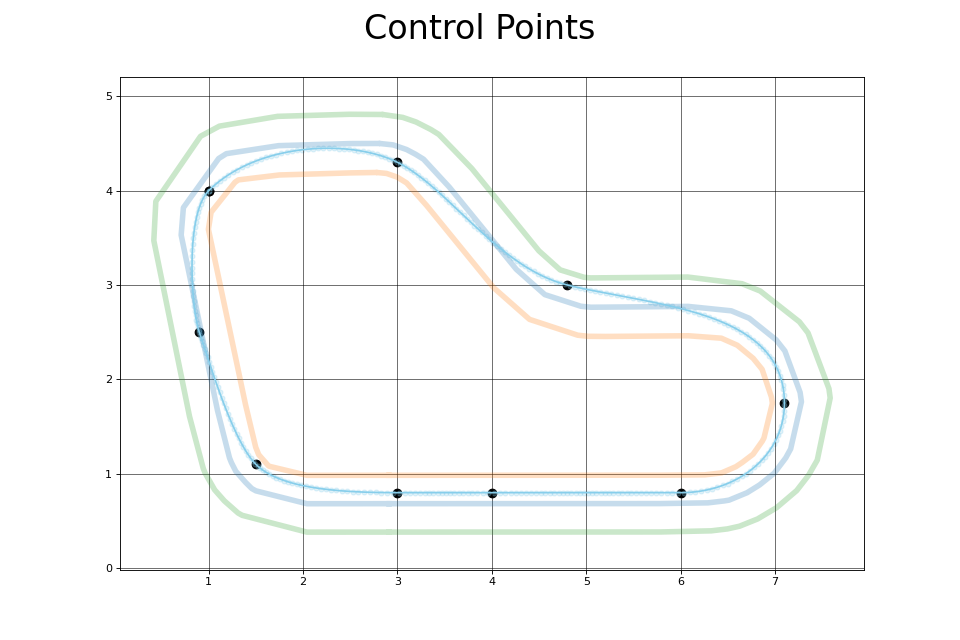

<IPython.core.display.Javascript object>


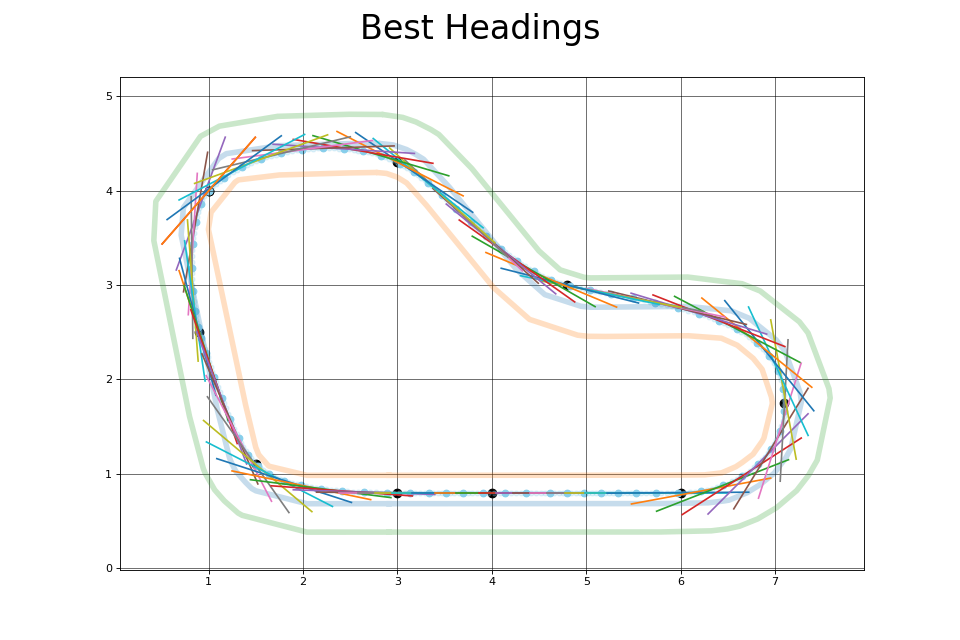

<IPython.core.display.Javascript object>


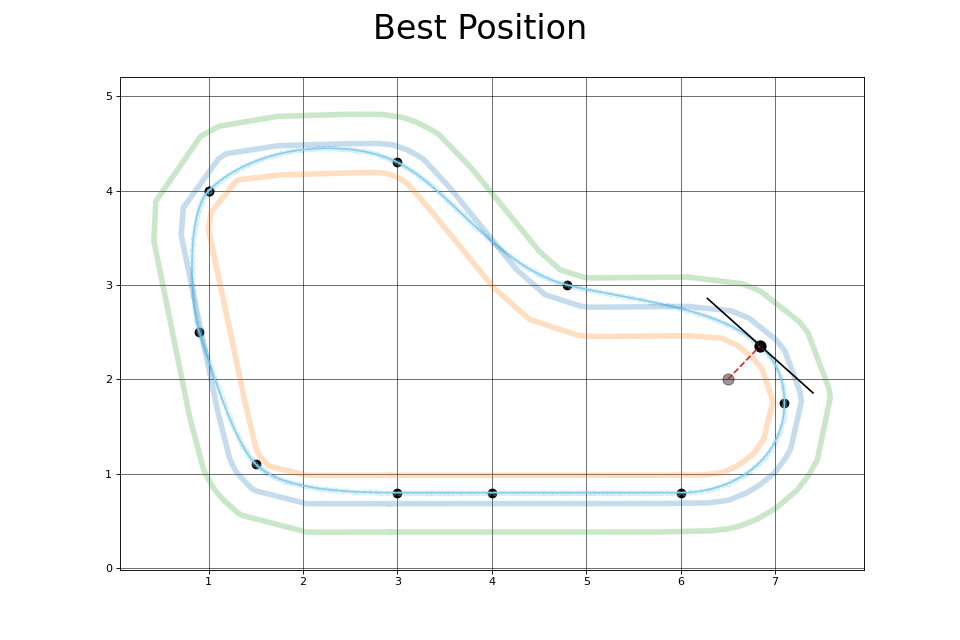

Parameters : {'all_wheels_on_track': True, 'track_width': 0.4, 'is_reversed': False, 'distance_from_center': 0.045, 'heading': -33.04080990261673, 'x': 1.55, 'y': 1}
Heading : 326.95919009738327
Best Position : [1.57705928 1.03622196]
Slope : [0.03213415646149165, -0.020900720981390952]
Best Heading : 326.95919009738327
Best Position Difference : 0.04521321251944206
Best Heading Difference : 0.0
Position Reward : 3.821311736334005
Heading Reward : 4.0
Reward : 233.63877417990412


<IPython.core.display.Javascript object>


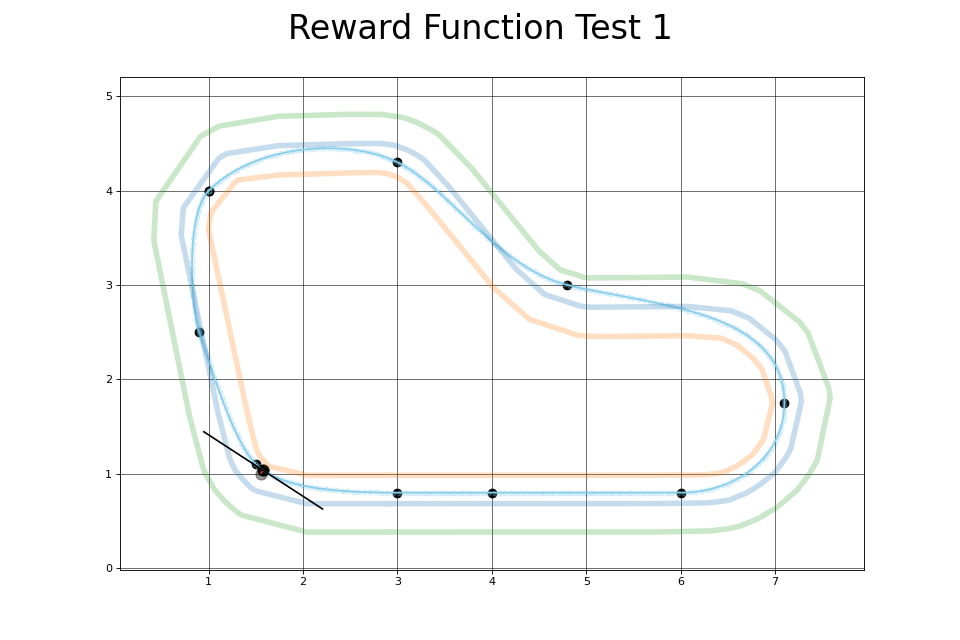

Parameters : {'all_wheels_on_track': True, 'track_width': 0.4, 'is_reversed': False, 'distance_from_center': 0.045, 'heading': 138.1858261265159, 'x': 6.5, 'y': 2}
Heading : 138.1858261265159
Best Position : [6.8435653  2.35712111]
Slope : [-0.03610270853175024, 0.032295621295896026]
Best Heading : 138.1858261265159
Best Position Difference : 0.49555282414019597
Best Heading Difference : 0.0
Position Reward : 2.3758754050366186
Heading Reward : 4.0
Reward : 90.31654304412666


<IPython.core.display.Javascript object>


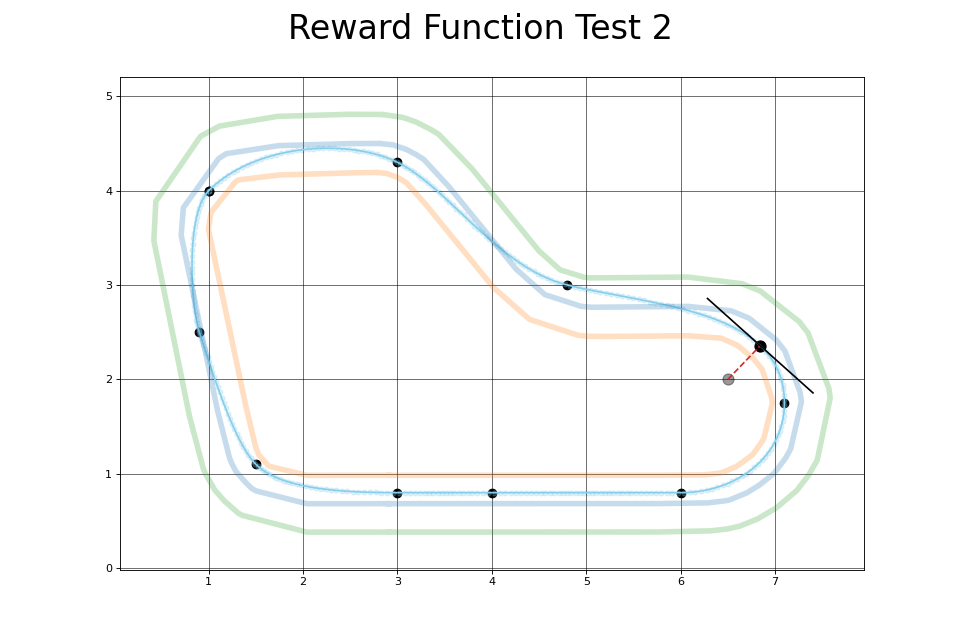

Parameters : {'all_wheels_on_track': True, 'track_width': 0.4, 'is_reversed': False, 'distance_from_center': 0.045, 'heading': 30, 'x': 4.5, 'y': 3}
Heading : 30
Best Position : [4.53509162 3.096563  ]
Slope : [-0.04625746179007617, 0.023022527379013003]
Best Heading : 153.54028274420534
Best Position Difference : 0.10274159043935353
Best Heading Difference : 123.54028274420534
Position Reward : 3.6009555821004358
Heading Reward : 2.7450940918893707
Reward : 97.71247163752781


<IPython.core.display.Javascript object>


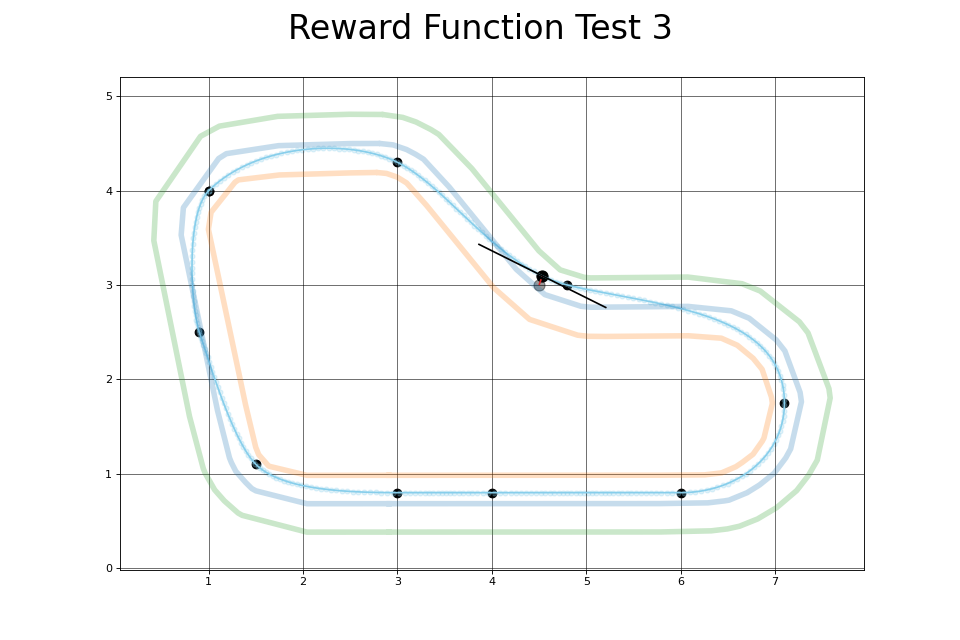

Parameters : {'all_wheels_on_track': True, 'track_width': 0.4, 'is_reversed': False, 'distance_from_center': 0.045, 'heading': -140, 'x': 2, 'y': 4.5}
Heading : 220
Best Position : [1.99251734 4.43351453]
Slope : [-0.05564453028977456, -0.007360261966010029]
Best Heading : 187.53493658108744
Best Position Difference : 0.06690521234618646
Best Heading Difference : 32.465063418912564
Position Reward : 3.737240737679253
Heading Reward : 3.647409637496604
Reward : 185.81091888203983


<IPython.core.display.Javascript object>


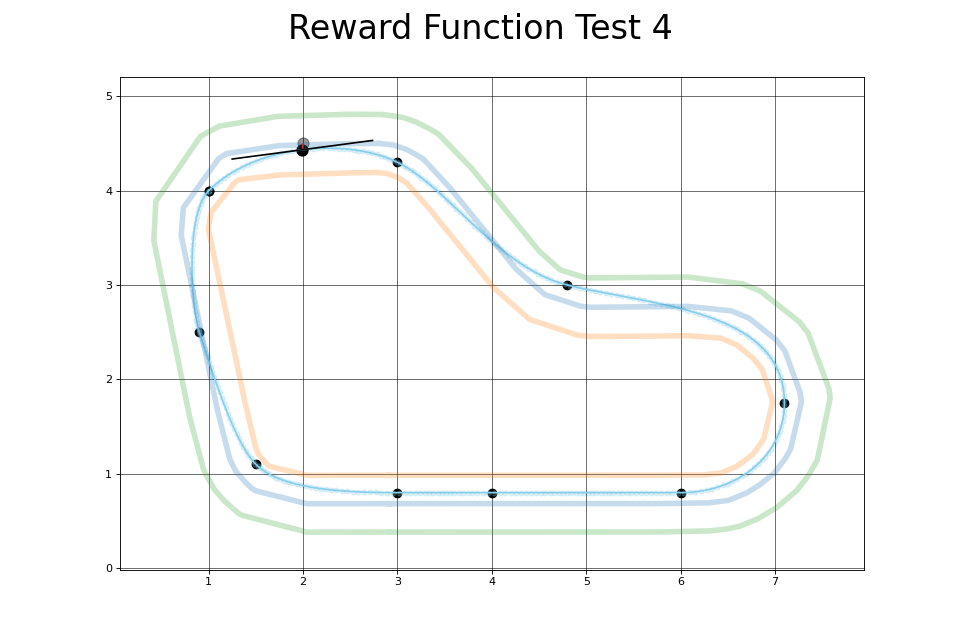

In [83]:
track = "reinvent_base"

track_waypoints = get_track_waypoints(track)

points, tangents, scales = choose_controlpoints(
    [
        #point          #tangent    #scale
        ([1., 4.],      [-1, -1],     .5),
        ([.9, 2.5],     [.35, -1],  .5),
        ([1.5, 1.1],    [1, -1],    .5),
        ([3, .8],       [1, 0],    1.25),
        ([4, .8],       [1, 0],    1.25),
        ([6, .8],       [1, 0],    1.25),
        ([7.1, 1.75],   [-0, 1],    1.15),
        ([4.8, 3.],     [-1, .25],  1),
        ([3., 4.3],     [-1, .5],   .75),
        ([1., 4.],      [-1, -1],     .75),
    ]
)

waypoints = sample_cubic_spline(points, tangents, scales, .05)

visualize_controlpoints(points, waypoints, track_waypoints)
visualize_best_headings((points, tangents, scales), waypoints, track_waypoints)
visualize_best_position([6.5, 2], waypoints, track_waypoints)

# 1
position = [1.55, 1]
best_heading = get_best_heading(position, waypoints)
params = get_test_params(position, best_heading)

visualize_reward_function(params, track_waypoints, num=1)

# 2
position = [6.5, 2]
best_heading = get_best_heading(position, waypoints)
params = get_test_params(position, best_heading)

visualize_reward_function(params, track_waypoints, num=2)

# 3
position = [4.5, 3]
params = get_test_params(position, 30)

visualize_reward_function(params, track_waypoints, num=3)

# 4
position = [2, 4.5]
params = get_test_params(position, -140)

visualize_reward_function(params, track_waypoints, num=4)

## Choose Control Points for re:Invent 2019 Track

<IPython.core.display.Javascript object>


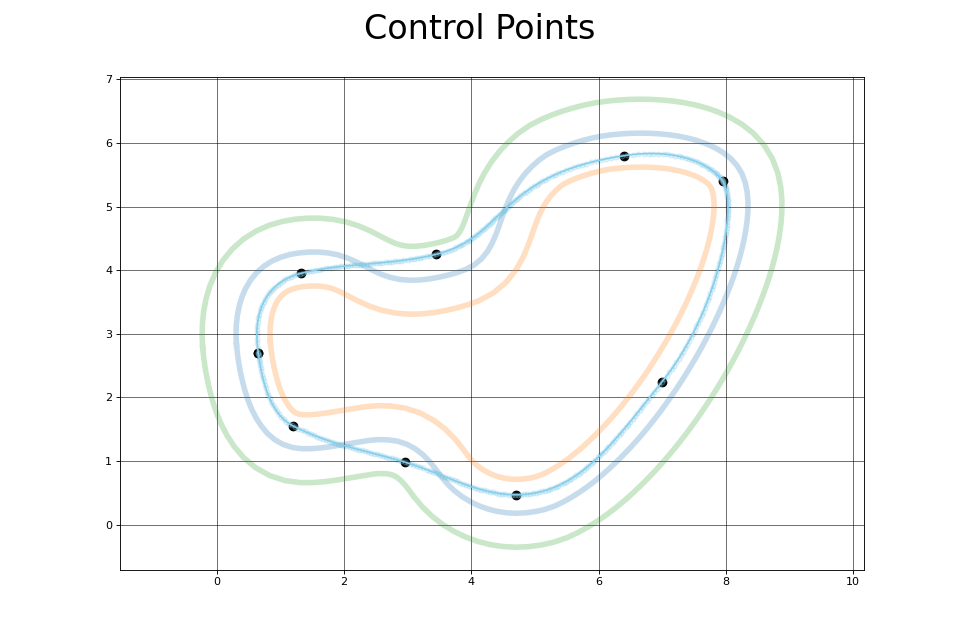

<IPython.core.display.Javascript object>


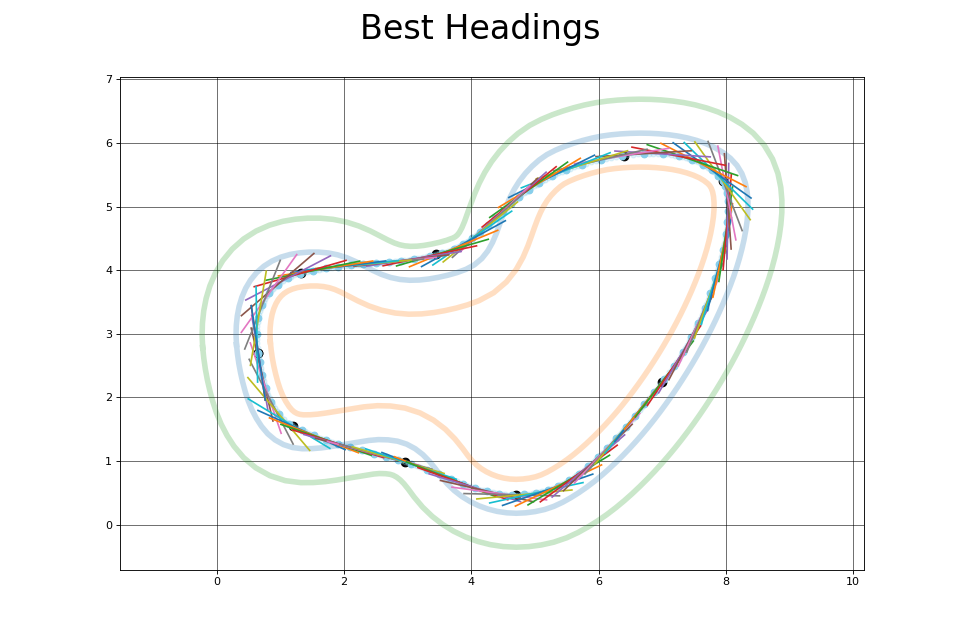

<IPython.core.display.Javascript object>


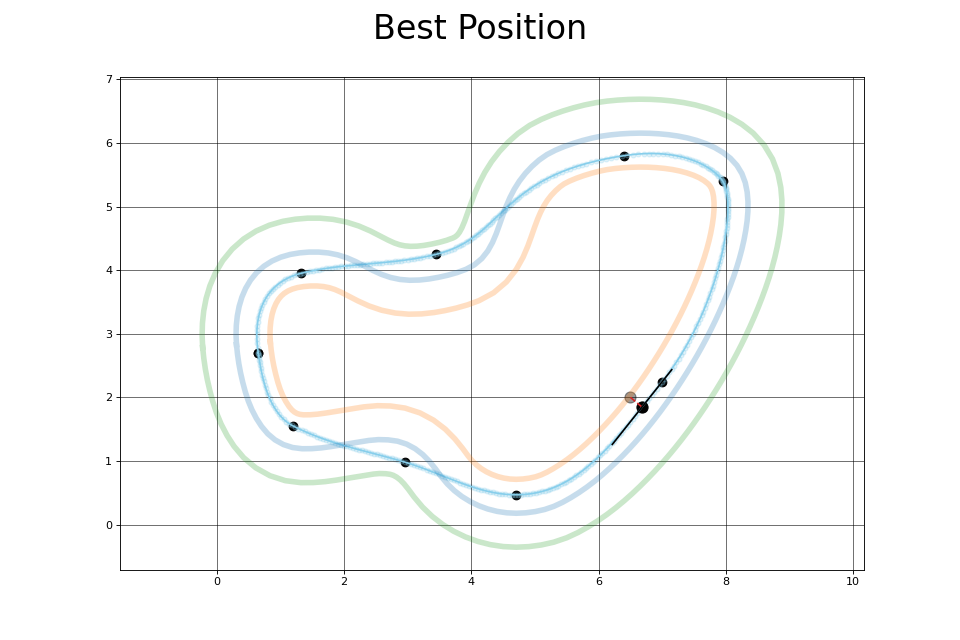

In [84]:
track = "reInvent2019_track"

track_waypoints = get_track_waypoints(track)

points, tangents, scales = choose_controlpoints(
    [
        #point          #tangent    #scale
        ([.65, 2.7],    [.15, -1],  .6),
        ([1.2, 1.55],   [1, -.5],   1),
        ([2.95, 0.985], [1, -.3],   1),
        ([4.7, .47],    [1, 0],     1),
        ([7, 2.25],     [.8, 1],    1),
        ([7.95, 5.4],   [-.65, 1],  .35),
        ([6.4, 5.8],    [-1, -.15], 1.8),
        ([3.45, 4.25],  [-1, -.25], 1),
        ([1.32, 3.95],  [-1, -.25], 1),
        ([.65, 2.7],    [.15, -1],  1.55),
    ]
)

waypoints = sample_cubic_spline(points, tangents, scales, .05)

visualize_controlpoints(points, waypoints, track_waypoints)
visualize_best_headings((points, tangents, scales), waypoints, track_waypoints)
visualize_best_position([6.5, 2], waypoints, track_waypoints)

## Choose Control Points for Tokyo Training Track

<IPython.core.display.Javascript object>


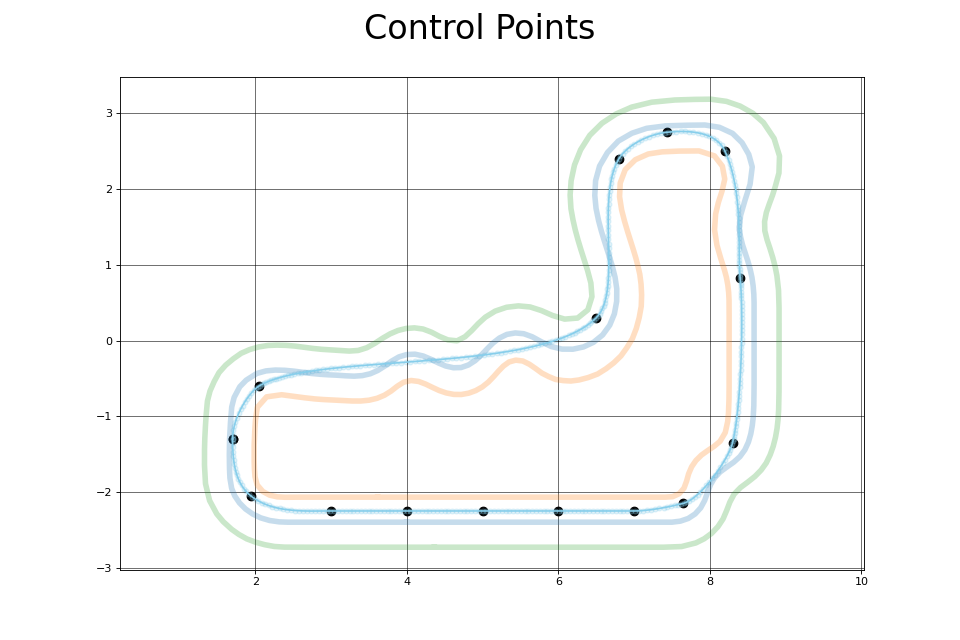

<IPython.core.display.Javascript object>


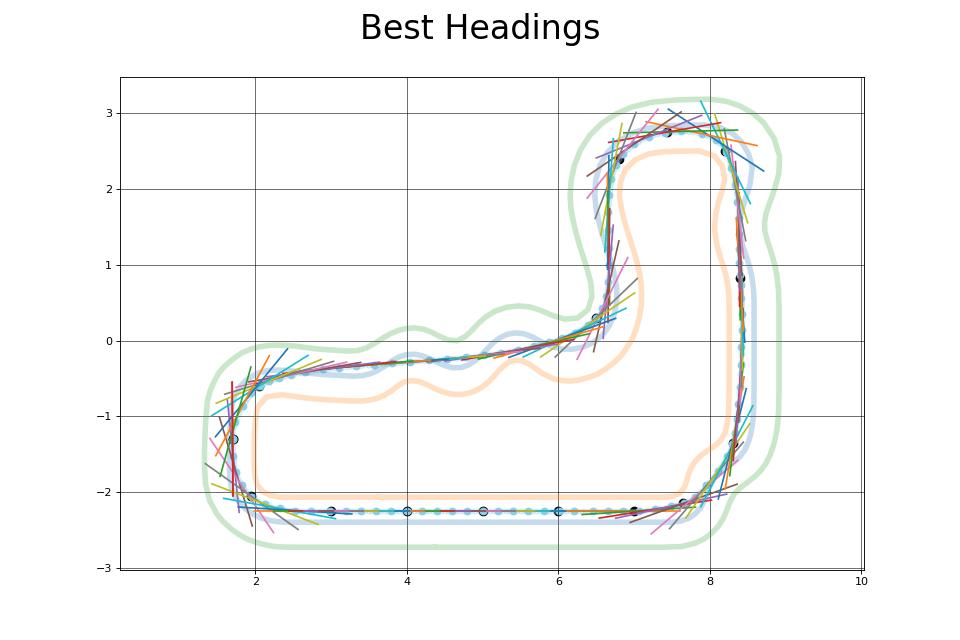

<IPython.core.display.Javascript object>


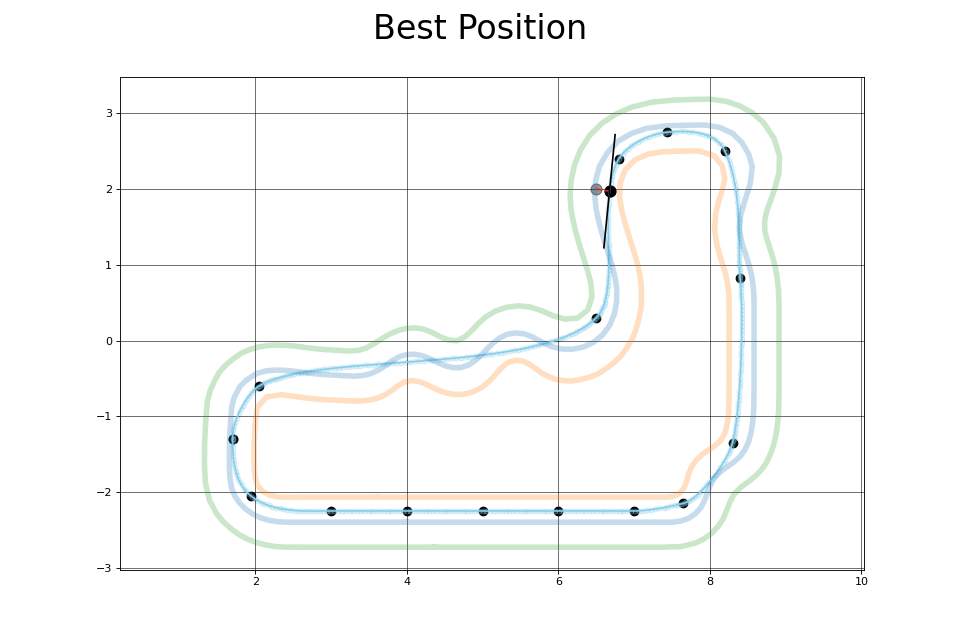

In [85]:
track = "Tokyo_Training_track"

track_waypoints = get_track_waypoints(track)

points, tangents, scales = choose_controlpoints(
    [
        #point          #tangent    #scale
        ([1.7, -1.3],   [0, -.8],   1.4),
        ([1.94, -2.05], [1, -.8],   .8),
        ([3, -2.25],    [1, 0],     1),
        ([4, -2.25],    [1, 0],     1),
        ([5, -2.25],    [1, 0],     1),
        ([6, -2.25],    [1, 0],     1),
        ([7, -2.25],    [1, 0],     1),
        ([7.65, -2.15], [1, .25],   .65),
        ([8.3, -1.35],  [.25, 1],   .65),
        ([8.4, .83],    [-.1, 1],   .65),
        ([8.2, 2.5],    [-.45, 1],  1),
        ([7.44, 2.75],  [-1, -.1],  1),
        ([6.8, 2.4],    [-.6, -1],  .75),
        ([6.5, 0.3],    [-1, -1],   .5),
        ([2.05, -0.6],  [-1, -.6],  .5),
        ([1.7, -1.3],   [0, -.8],    1.4),
    ]
)

waypoints = sample_cubic_spline(points, tangents, scales, .05)

visualize_controlpoints(points, waypoints, track_waypoints)
visualize_best_headings((points, tangents, scales), waypoints, track_waypoints)
visualize_best_position([6.5, 2], waypoints, track_waypoints)